<a href="https://colab.research.google.com/github/MiriamRunde/Qbias/blob/main/explore_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
!pip install datasets
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Load the MBIB political bias dataset
dataset_dict = load_dataset("mediabiasgroup/mbib-base")
political_dataset = dataset_dict['political_bias']

# Convert to a Pandas DataFrame
data = political_dataset.to_pandas()

example = data.head(5)

example.to_csv('example.csv')
print(data.head)

# Preprocess the data
data = data[['text', 'label']]  # Select relevant columns
#data = data.dropna()  # Remove NaN rows


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

mbib-aggregated/cognitive-bias.csv:   0%|          | 0.00/851k [00:00<?, ?B/s]

mbib-aggregated/fake-news.csv:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

mbib-aggregated/gender-bias.csv:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

hate-speech.csv:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

linguistic-bias.csv:   0%|          | 0.00/121M [00:00<?, ?B/s]

mbib-aggregated/political-bias.csv:   0%|          | 0.00/4.32M [00:00<?, ?B/s]

mbib-aggregated/racial-bias.csv:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

mbib-aggregated/text-level-bias.csv:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating cognitive_bias split:   0%|          | 0/7092 [00:00<?, ? examples/s]

Generating fake_news split:   0%|          | 0/8542 [00:00<?, ? examples/s]

Generating gender_bias split:   0%|          | 0/17940 [00:00<?, ? examples/s]

Generating hate_speech split:   0%|          | 0/339010 [00:00<?, ? examples/s]

Generating linguistic_bias split:   0%|          | 0/401862 [00:00<?, ? examples/s]

Generating political_bias split:   0%|          | 0/17704 [00:00<?, ? examples/s]

Generating racial_bias split:   0%|          | 0/9788 [00:00<?, ? examples/s]

Generating text_level_bias split:   0%|          | 0/9018 [00:00<?, ? examples/s]

<bound method NDFrame.head of                     id                                               text  \
0        029-0000067-5                               Sebastian Gorka Yes    
1       029-0000200-13  Suddenly his powerful former friends are retur...   
2        029-0001194-6   Malia Obama s private life as a young woman a...   
3       029-0000412-10  Jerry Springer I mean good God Other than his ...   
4        029-0000063-2  Jerry Drake Varnell of Sayre was arrested Augu...   
...                ...                                                ...   
17699   029-0000926-58                          Jim Acosta August 22 2017   
17700  029-0000879-120  Because Liz offers a ridiculously good guarant...   
17701   029-0000898-36                                 So great so great    
17702    029-0000094-8  On Forbes list of highest earning athletes bla...   
17703   029-0001030-16                  Charles Hoskinson October 13 2017   

       label  dataset_id  
0          0      

In [3]:
data['text'] = data['text'].astype(str)
data['label'] = data['label'].astype(int)

## Text Preprocessing

In [ ]:
import re

# Cleaning function for text
def clean_text(raw_text):
    # Remove numeric IDs and metadata patterns (e.g., "029-0000067-5")
    cleaned = re.sub(r'\b\d+[-\d]*\b', '', raw_text)
    cleaned = re.sub(r'\b\d+\b', '', cleaned)

    # Replace multiple spaces/newlines with a single space
    cleaned = re.sub(r'\s+', ' ', cleaned)

    # Remove special characters (except apostrophes and periods for sentence structure)
    cleaned = re.sub(r"[^a-zA-Z0-9\s.,']", '', cleaned)

    # Convert to lowercase for consistency
    cleaned = cleaned.lower().strip()

    return cleaned

# Apply cleaning to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Display a sample of the cleaned data
data[['text', 'cleaned_text']].head()


,text,cleaned_text
0,Sebastian Gorka Yes,sebastian gorka yes
1,Suddenly his powerful former friends are retur...,suddenly his powerful former friends are retur...
2,Malia Obama s private life as a young woman a...,malia obama s private life as a young woman a ...
3,Jerry Springer I mean good God Other than his ...,jerry springer i mean good god other than his ...
4,Jerry Drake Varnell of Sayre was arrested Augu...,jerry drake varnell of sayre was arrested augu...


## Embedding Based

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

# Load the dataset (assuming it's already cleaned and available as df['cleaned_text'] and df['label'])
# df['cleaned_text']: Preprocessed text
# df['label']: Binary label for political bias (e.g., 0: non-biased, 1: biased)

# Ensure required columns exist
if 'cleaned_text' not in data.columns or 'label' not in data.columns:
    raise ValueError("Dataset must contain 'cleaned_text' and 'label' columns.")

# -------------------------------------------------------------------
# BASELINE: TF-IDF VECTORIZATION
# -------------------------------------------------------------------

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # Adjust max_features as needed

# Generate TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(data['cleaned_text'])

# Print TF-IDF shape and a sample
print(f"TF-IDF feature matrix shape: {tfidf_features.shape}")

# Get feature names (terms)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Example: Inspect the top TF-IDF terms for a sample document
sample_index = 45
sample_tfidf_vector = tfidf_features[sample_index].toarray()[0]
top_terms_indices = sample_tfidf_vector.argsort()[-10:][::-1]
print("Top TF-IDF terms for sample document:")
for idx in top_terms_indices:
    print(f"{tfidf_feature_names[idx]}: {sample_tfidf_vector[idx]}")



# -------------------------------------------------------------------
# SAVE RESULTS FOR LATER ANALYSIS
# -------------------------------------------------------------------

# Save TF-IDF and Sentence-BERT embeddings to files
np.save("tfidf_features.npy", tfidf_features.toarray())  # TF-IDF matrix
np.save("sbert_embeddings.npy", sbert_embeddings)  # Sentence-BERT embeddings
data.to_csv("cleaned_dataset_with_embeddings.csv", index=False)  # Dataset with text and labels

print("TF-IDF features and Sentence-BERT embeddings have been saved for later analysis.")


TF-IDF feature matrix shape: (17704, 1000)
Top TF-IDF terms for sample document:
giving: 0.4644813942993598
saw: 0.4374245882997913
pic: 0.42865347150673977
com: 0.38669709080390063
woman: 0.37989117417609786
twitter: 0.33958948896072566
gender: 0.0
future: 0.0
game: 0.0
gave: 0.0


NameError: name 'sbert_embeddings' is not defined

Top 20 terms with the highest average TF-IDF scores across all documents:
trump: 0.0370
said: 0.0244
people: 0.0208
president: 0.0203
clinton: 0.0201
just: 0.0140
like: 0.0132
hillary: 0.0124
donald: 0.0116
time: 0.0114
news: 0.0111
obama: 0.0110
police: 0.0110
white: 0.0109
america: 0.0105
don: 0.0101
new: 0.0101
october: 0.0099
american: 0.0099
know: 0.0098


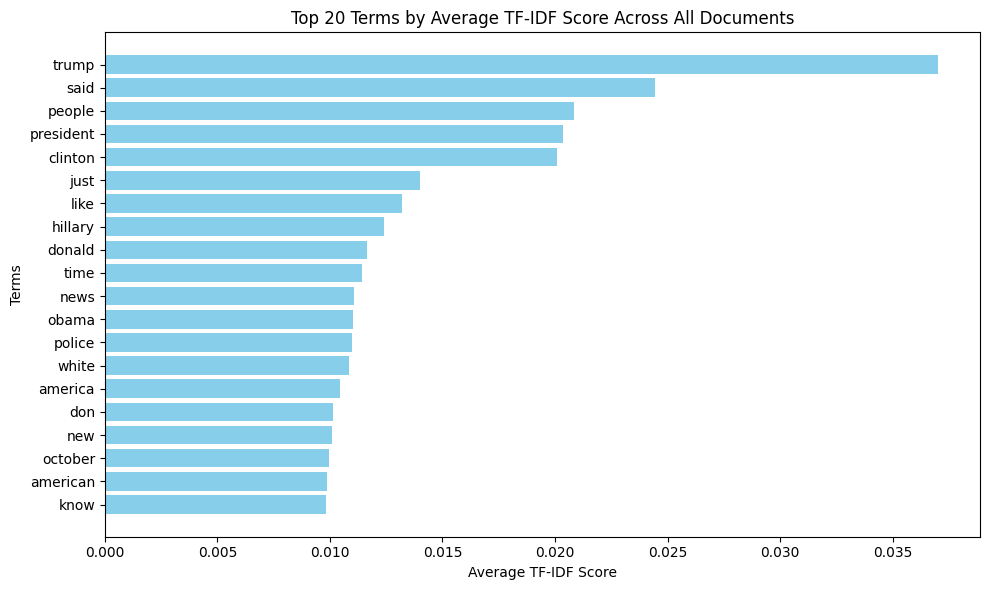

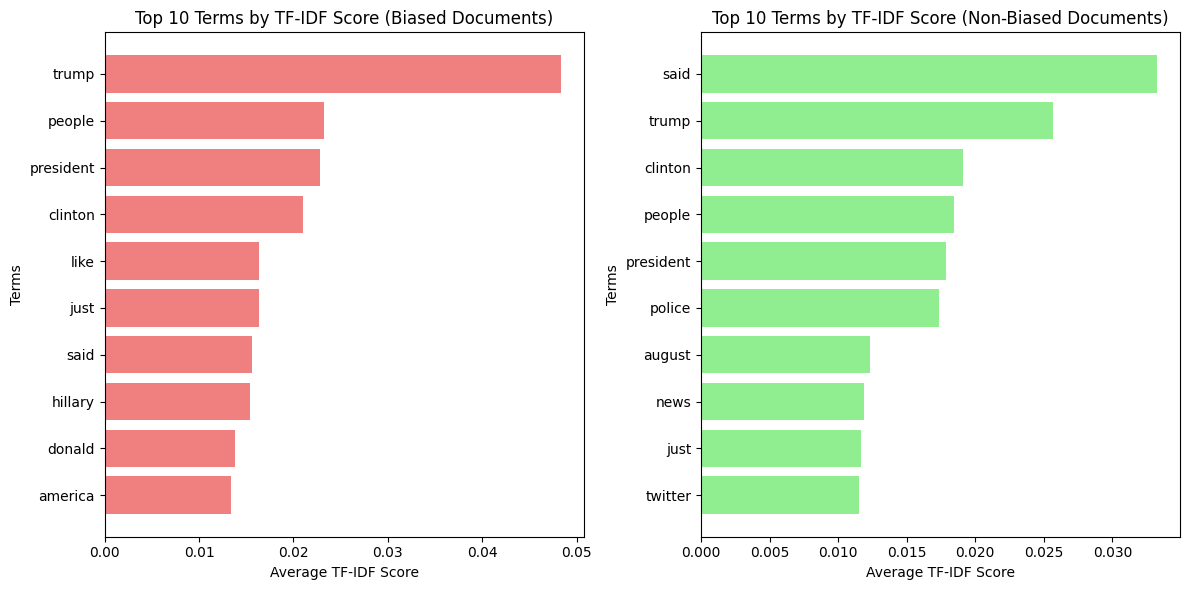

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Inspect Key Terms Across the Corpus
# Calculate the average TF-IDF score for each term across all documents
average_tfidf_scores = np.asarray(tfidf_features.mean(axis=0)).flatten()

# Get the top 20 terms with the highest average TF-IDF scores
top_indices = average_tfidf_scores.argsort()[-20:][::-1]
top_terms = [tfidf_feature_names[i] for i in top_indices]
top_scores = average_tfidf_scores[top_indices]

# Display the top terms and their scores
print("Top 20 terms with the highest average TF-IDF scores across all documents:")
for term, score in zip(top_terms, top_scores):
    print(f"{term}: {score:.4f}")

# Plot the top 20 terms
plt.figure(figsize=(10, 6))
plt.barh(top_terms[::-1], top_scores[::-1], color="skyblue")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Terms")
plt.title("Top 20 Terms by Average TF-IDF Score Across All Documents")
plt.tight_layout()
plt.show()

# 2. Visualize TF-IDF Distributions for Biased vs. Non-Biased Documents
# Split the TF-IDF matrix by bias label
biased_mask = data['label'] == 1
non_biased_mask = data['label'] == 0

# Calculate average TF-IDF scores for biased and non-biased documents
biased_tfidf = np.asarray(tfidf_features[biased_mask].mean(axis=0)).flatten()
non_biased_tfidf = np.asarray(tfidf_features[non_biased_mask].mean(axis=0)).flatten()

# Get the top 10 distinguishing terms for biased and non-biased documents
top_biased_indices = biased_tfidf.argsort()[-10:][::-1]
top_non_biased_indices = non_biased_tfidf.argsort()[-10:][::-1]

top_biased_terms = [tfidf_feature_names[i] for i in top_biased_indices]
top_non_biased_terms = [tfidf_feature_names[i] for i in top_non_biased_indices]

top_biased_scores = biased_tfidf[top_biased_indices]
top_non_biased_scores = non_biased_tfidf[top_non_biased_indices]

# Plot the top terms for biased and non-biased documents
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(top_biased_terms[::-1], top_biased_scores[::-1], color="lightcoral")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Terms")
plt.title("Top 10 Terms by TF-IDF Score (Biased Documents)")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.barh(top_non_biased_terms[::-1], top_non_biased_scores[::-1], color="lightgreen")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Terms")
plt.title("Top 10 Terms by TF-IDF Score (Non-Biased Documents)")
plt.tight_layout()

plt.show()


In [ ]:
# Calculate the average TF-IDF scores for biased and non-biased documents
biased_tfidf = np.asarray(tfidf_features[biased_mask].mean(axis=0)).flatten()
non_biased_tfidf = np.asarray(tfidf_features[non_biased_mask].mean(axis=0)).flatten()

# Get the top 10 terms for biased documents
top_biased_indices = biased_tfidf.argsort()[-10:][::-1]
top_biased_terms = [tfidf_feature_names[i] for i in top_biased_indices]
top_biased_scores = biased_tfidf[top_biased_indices]

# Get the corresponding TF-IDF scores for these terms in non-biased documents
top_biased_in_non_biased_scores = [non_biased_tfidf[i] for i in top_biased_indices]

# Get the top 10 terms for non-biased documents
top_non_biased_indices = non_biased_tfidf.argsort()[-10:][::-1]
top_non_biased_terms = [tfidf_feature_names[i] for i in top_non_biased_indices]
top_non_biased_scores = non_biased_tfidf[top_non_biased_indices]

# Get the corresponding TF-IDF scores for these terms in biased documents
top_non_biased_in_biased_scores = [biased_tfidf[i] for i in top_non_biased_indices]

# Combine results into a readable format
biased_results = pd.DataFrame({
    "Term": top_biased_terms,
    "Biased Score": top_biased_scores,
    "Non-Biased Score (Same Terms)": top_biased_in_non_biased_scores
})

non_biased_results = pd.DataFrame({
    "Term": top_non_biased_terms,
    "Non-Biased Score": top_non_biased_scores,
    "Biased Score (Same Terms)": top_non_biased_in_biased_scores
})


print(non_biased_results)


        Term  Non-Biased Score  Biased Score (Same Terms)
0       said          0.033265                   0.015622
1      trump          0.025692                   0.048355
2    clinton          0.019138                   0.021056
3     people          0.018464                   0.023183
4  president          0.017880                   0.022807
5     police          0.017335                   0.004665
6     august          0.012318                   0.002998
7       news          0.011925                   0.010246
8       just          0.011685                   0.016332
9    twitter          0.011549                   0.006758


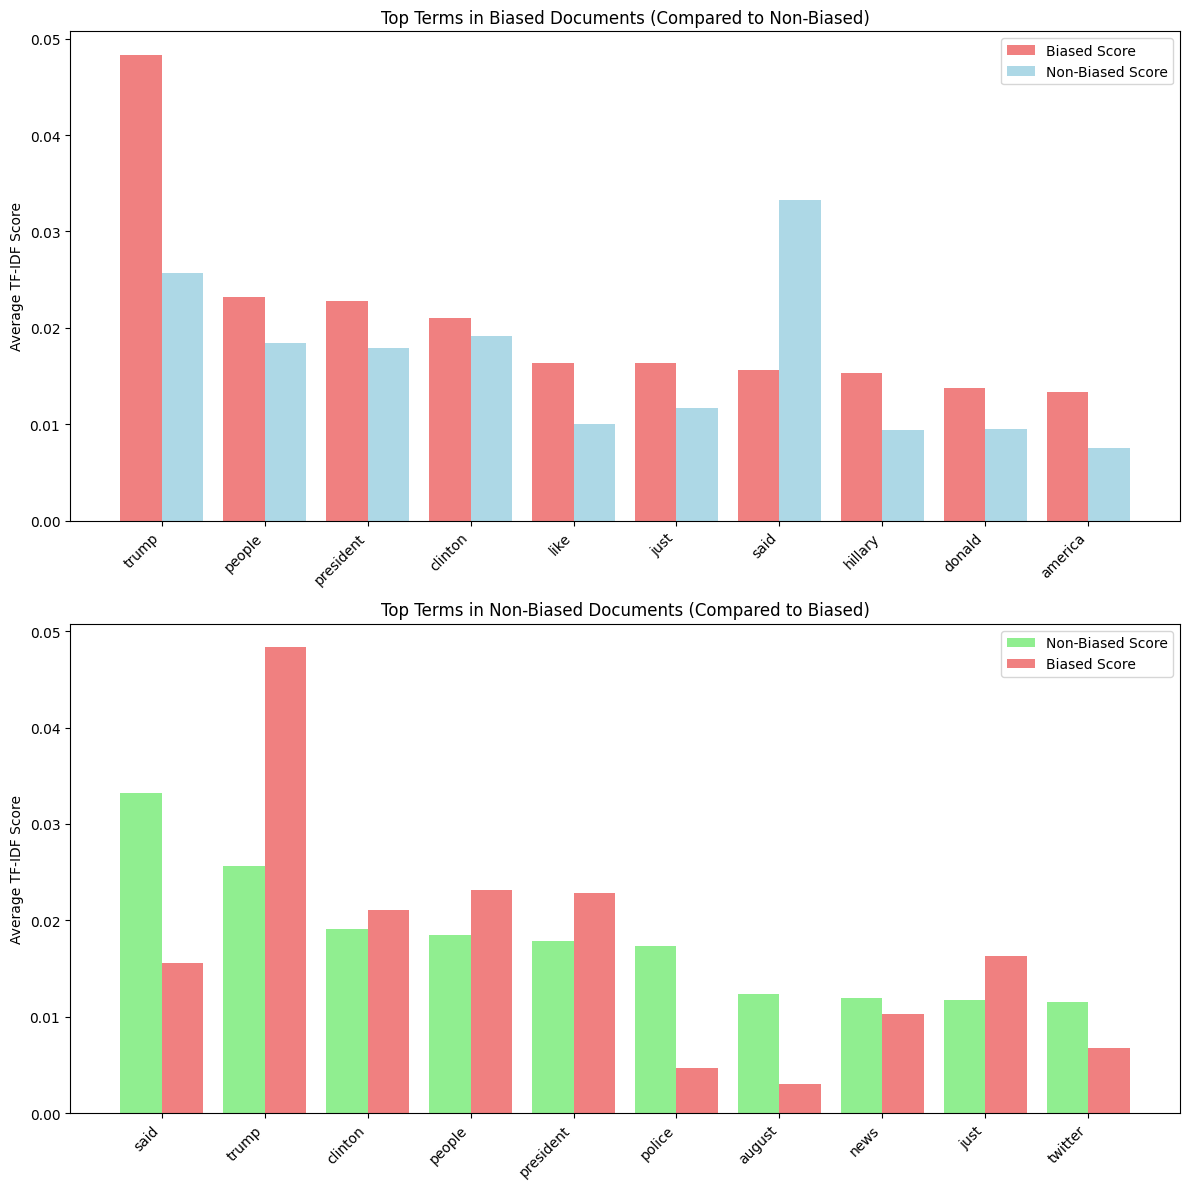

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np



# Create the plot
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# Plot for biased terms
x_biased = np.arange(len(biased_results["Term"]))
axs[0].bar(x_biased - 0.2, biased_results["Biased Score"], width=0.4, label="Biased Score", color="lightcoral")
axs[0].bar(x_biased + 0.2, biased_results["Non-Biased Score (Same Terms)"], width=0.4, label="Non-Biased Score", color="lightblue")
axs[0].set_xticks(x_biased)
axs[0].set_xticklabels(biased_results["Term"], rotation=45, ha="right")
axs[0].set_ylabel("Average TF-IDF Score")
axs[0].set_title("Top Terms in Biased Documents (Compared to Non-Biased)")
axs[0].legend()

# Plot for non-biased terms
x_non_biased = np.arange(len(non_biased_results["Term"]))
axs[1].bar(x_non_biased - 0.2, non_biased_results["Non-Biased Score"], width=0.4, label="Non-Biased Score", color="lightgreen")
axs[1].bar(x_non_biased + 0.2, non_biased_results["Biased Score (Same Terms)"], width=0.4, label="Biased Score", color="lightcoral")
axs[1].set_xticks(x_non_biased)
axs[1].set_xticklabels(non_biased_results["Term"], rotation=45, ha="right")
axs[1].set_ylabel("Average TF-IDF Score")
axs[1].set_title("Top Terms in Non-Biased Documents (Compared to Biased)")
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()



## BERT Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Ensure you have a column `df['cleaned_text']` containing the cleaned text
# Initialize the Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and efficient

# Generate embeddings for the cleaned text
print("Generating Sentence-BERT embeddings...")
sbert_embeddings = sbert_model.encode(data['cleaned_text'].tolist(), show_progress_bar=True)

# Convert to NumPy array for easier processing
sbert_embeddings = np.array(sbert_embeddings)

# Save embeddings for later use (optional)
np.save("sbert_embeddings.npy", sbert_embeddings)

# Print the shape of the embeddings
print(f"Generated Sentence-BERT embeddings with shape: {sbert_embeddings.shape}")


Generating Sentence-BERT embeddings...


Batches:   0%|          | 0/554 [00:00<?, ?it/s]

Generated Sentence-BERT embeddings with shape: (17704, 384)


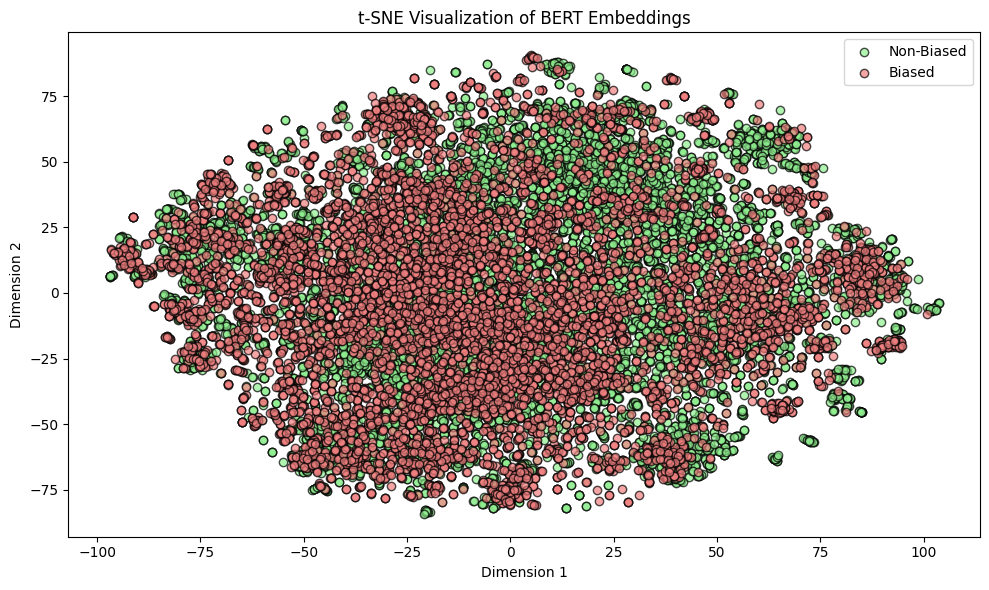

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Ensure you have the Sentence-BERT embeddings and labels available
# sbert_embeddings: Array of embeddings (e.g., generated by Sentence-BERT)
# df['label']: Labels for biased (1) and non-biased (0)

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(sbert_embeddings)

# Separate embeddings by labels
biased_embeddings = embeddings_2d[data['label'] == 1]
non_biased_embeddings = embeddings_2d[data['label'] == 0]

# Plot the embeddings
plt.figure(figsize=(10, 6))
plt.scatter(non_biased_embeddings[:, 0], non_biased_embeddings[:, 1],
            c='lightgreen', label='Non-Biased', alpha=0.7, edgecolors='k')
plt.scatter(biased_embeddings[:, 0], biased_embeddings[:, 1],
            c='lightcoral', label='Biased', alpha=0.7, edgecolors='k')
plt.title('t-SNE Visualization of BERT Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:

# Split into training and evaluation datasets
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42
)

In [8]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# In your BiasDataset class's __getitem__ method:
class BiasDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Check if the text is valid before tokenizing
        text = self.texts.iloc[idx]
        if not isinstance(text, str) or not text:  # Check if text is a non-empty string
            text = ""  # or any default value you want to use

        tokenized_data = tokenizer(
            text,  # Use the checked text
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        return {
            "input_ids": tokenized_data["input_ids"].squeeze(0),
            "attention_mask": tokenized_data["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

# Create PyTorch datasets
train_dataset = BiasDataset(train_texts, train_labels)
eval_dataset = BiasDataset(eval_texts, eval_labels)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
import re


# Cleaning function
def clean_text(raw_text):
    # Remove numeric IDs and metadata patterns (e.g., "0 29 029-0000200-13")
    cleaned = re.sub(r'\b\d+[-\d]*\b', '', raw_text)
    cleaned = re.sub(r'\b\d+\b', '', cleaned)

    # Replace multiple spaces/newlines with a single space
    cleaned = re.sub(r'\s+', ' ', cleaned)

    # Remove special characters (except apostrophes and periods for sentence structure)
    cleaned = re.sub(r"[^a-zA-Z0-9\s.,']", '', cleaned)

    # Convert to lowercase for consistency
    cleaned = cleaned.lower().strip()

    return cleaned

# Apply cleaning
cleaned_text = clean_text(raw_text)

# Print results
print("Original Text:\n", raw_text)
print("\nCleaned Text:\n", cleaned_text)


In [4]:
# Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 Training: 100%|██████████| 886/886 [09:25<00:00,  1.57it/s, loss=0.139]


Epoch 1, Loss: 0.5487231481021467


Evaluating: 100%|██████████| 222/222 [00:49<00:00,  4.50it/s]


Precision: 0.8569, Recall: 0.5356, F1 Score: 0.6592


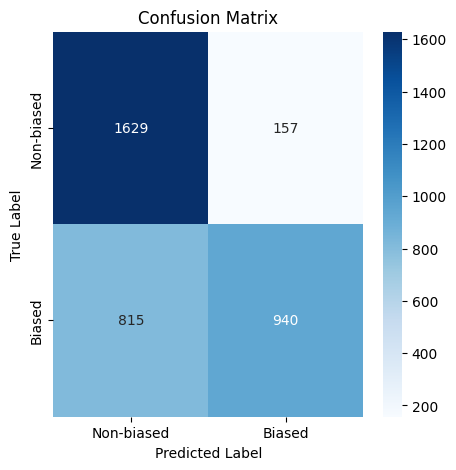

Epoch 2 Training: 100%|██████████| 886/886 [09:26<00:00,  1.56it/s, loss=0.219]


Epoch 2, Loss: 0.4075012352931446


Evaluating: 100%|██████████| 222/222 [00:49<00:00,  4.50it/s]


Precision: 0.8293, Recall: 0.7088, F1 Score: 0.7644


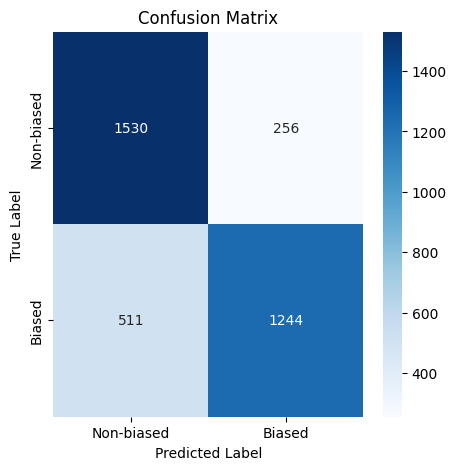

Epoch 3 Training: 100%|██████████| 886/886 [09:26<00:00,  1.56it/s, loss=0.293]


Epoch 3, Loss: 0.27671497868495926


Evaluating: 100%|██████████| 222/222 [00:49<00:00,  4.50it/s]


Precision: 0.7942, Recall: 0.7852, F1 Score: 0.7897


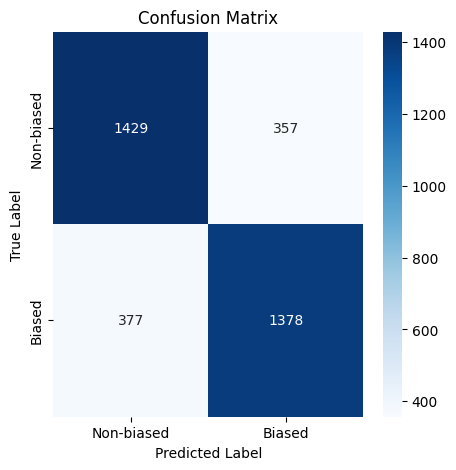

Fine-tuning complete. Model saved to 'fine_tuned_roberta'.


In [9]:
# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# Load the pretrained RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Training function
def train_model(model, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training")

    for batch in progress_bar:
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluation function
def evaluate_model(model, eval_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(eval_loader, desc="Evaluating")

    with torch.no_grad():
        for batch in progress_bar:
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Ensure valid input for the model
            if input_ids.size(0) == 0:
                continue

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Display confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-biased", "Biased"], yticklabels=["Non-biased", "Biased"])
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

# Train and evaluate the model
epochs = 3
for epoch in range(epochs):
    train_model(model, train_loader, optimizer, epoch)
    evaluate_model(model, eval_loader)

# Save the fine-tuned model
model.save_pretrained("fine_tuned_roberta")
tokenizer.save_pretrained("fine_tuned_roberta")

print("Fine-tuning complete. Model saved to 'fine_tuned_roberta'.")


In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer


In [12]:
# Load fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_roberta").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_roberta")

# Function to make predictions
def make_predictions(texts, model, tokenizer):
    results = []
    for text in texts:
        # Check if the text is a valid string
        if isinstance(text, str) and text.strip():
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")
            with torch.no_grad():
                logits = model(**inputs).logits
                probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
                predicted_label = probs.argmax()
                confidence = probs[predicted_label]

            results.append({
                "text": text,
                "predicted_label": predicted_label,
                "confidence": confidence
            })
        else:
            # Handle invalid text (e.g., None or empty string)
            results.append({
                "text": text,  # Or you can use a placeholder like "[EMPTY]"
                "predicted_label": -1,  # Or any other value to indicate invalid
                "confidence": 0.0  # Or a value indicating low confidence
            })
    return pd.DataFrame(results)


# Clean the text data
texts = [text if isinstance(text, str) and text.strip() else "[EMPTY]" for text in data['text'].tolist()]
actual_labels = data['label'].tolist()

# Make predictions
texts = data['text'].tolist()
actual_labels = data['label'].tolist()
predictions_df = make_predictions(texts, model, tokenizer)

# Add actual labels to predictions
predictions_df["actual_label"] = actual_labels
predictions_df.to_csv("predictions_with_labels.csv", index=False)


In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
!pip install captum
from captum.attr import LayerIntegratedGradients, visualization
import torch

# Load the fine-tuned RoBERTa model and tokenizer
checkpoint = "fine_tuned_roberta"  # Replace with the path to your model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint).to("cuda")
model.eval()

# Define the forward function for Captum
def forward_func(inputs, attention_mask=None):
    output = model(input_ids=inputs, attention_mask=attention_mask)
    return output.logits

# Initialize Layer Integrated Gradients
lig = LayerIntegratedGradients(forward_func, model.roberta.embeddings)
# ... (previous code) ...

# Compute attributions for a given text
def compute_attributions(text, label):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Reference baseline (all zeros)
    reference_input_ids = torch.zeros_like(input_ids)

    # Compute attributions
    # Change 'target' to a tensor
    attributions, delta = lig.attribute(
        inputs=input_ids,
        baselines=reference_input_ids,
        additional_forward_args=(attention_mask,),
        n_steps=50,
        return_convergence_delta=True,
        target=torch.tensor([label]).to("cuda")  # Convert label to a tensor
    )

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    return tokens, attributions, delta



# Summarize attributions for each token
def summarize_attributions(attributions):
    attributions = attributions / (abs(attributions).max() + 1e-10)
    return attributions

# Visualize attributions
def visualize_attributions(text, pred_label, true_label, pred_prob):
    tokens, raw_attributions, delta = compute_attributions(text, pred_label)
    normalized_attributions = summarize_attributions(raw_attributions)

    # Visualization data
    viz_info = visualization.VisualizationDataRecord(
        word_attributions=normalized_attributions.tolist(),
        pred_prob=pred_prob,
        pred_class=pred_label,
        true_class=true_label,
        attr_class=pred_label,
        attr_score=normalized_attributions.sum(),
        raw_input_ids=tokens,
        convergence_score=delta
    )

    # Save the visualization to an HTML file
    html = visualization.visualize_text([viz_info])
    with open("captum_viz.html", "w") as f:
        f.write(html.data)

    print("Visualization saved to 'captum_viz.html'.")

# Apply to one example
example_text = data.loc[12345, "text"]  # Replace with a valid text from your dataset
example_label = data.loc[12345, "label"]  # Replace with the actual label
inputs = tokenizer(example_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")

# Predict
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    pred_label = probs.argmax()
    pred_prob = probs[pred_label]

# Generate visualization
visualize_attributions(example_text, pred_label, example_label, pred_prob)


# Apply to one example
example_text = data.loc[3, "text"]  # Replace with a valid text from your dataset
example_label = data.loc[3, "label"]  # Replace with the actual label
inputs = tokenizer(example_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")

# Predict
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    pred_label = probs.argmax()
    pred_prob = probs[pred_label]

# Generate visualization
visualize_attributions(example_text, pred_label, example_label, pred_prob)



# Apply to one example
example_text = data.loc[8977, "text"]  # Replace with a valid text from your dataset
example_label = data.loc[8977, "label"]  # Replace with the actual label
inputs = tokenizer(example_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")

# Predict
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    pred_label = probs.argmax()
    pred_prob = probs[pred_label]

# Generate visualization
visualize_attributions(example_text, pred_label, example_label, pred_prob)


Visualization saved to 'captum_viz.html'.


Visualization saved to 'captum_viz.html'.


Visualization saved to 'captum_viz.html'.


In [23]:
# Apply to one example
example_text = data.loc[15500, "text"]  # Replace with a valid text from your dataset
example_label = data.loc[15500, "label"]  # Replace with the actual label
inputs = tokenizer(example_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")

# Predict
with torch.no_grad():
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    pred_label = probs.argmax()
    pred_prob = probs[pred_label]

# Generate visualization
visualize_attributions(example_text, pred_label, example_label, pred_prob)

Visualization saved to 'captum_viz.html'.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
!pip install captum
from captum.attr import LayerIntegratedGradients, visualization
import torch

# Ensure model and tokenizer match your fine-tuned setup
checkpoint = "fine_tuned_roberta"  # Replace with your fine-tuned model checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.to("cuda")
model.eval()

# Define forward function for Captum
def forward_func(inputs, attention_mask=None):
    output = model(input_ids=inputs, attention_mask=attention_mask)
    return output.logits

# Initialize Layer Integrated Gradients
lig = LayerIntegratedGradients(forward_func, model.roberta.embeddings)

# Compute attributions for a given example
def compute_attributions_for_example(text, true_label, target_label):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Define reference inputs (all zeros)
    reference_input_ids = torch.zeros_like(input_ids)

    # Compute attributions
    attributions, delta = lig.attribute(
        inputs=input_ids,
        baselines=reference_input_ids,
        additional_forward_args=(attention_mask,),
        n_steps=50,
        return_convergence_delta=True,
        target=target_label
    )

    # Convert tokens to human-readable form
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    return tokens, attributions, delta

# Summarize attributions for visualization
def summarize_attributions(attributions):
    return attributions / (torch.norm(torch.tensor(attributions)) + 1e-10)

# Visualize attributions
def visualize_attributions(text, true_label, pred_label, pred_prob):
    tokens, raw_attributions, delta = compute_attributions_for_example(text, true_label, pred_label)
    normalized_attributions = summarize_attributions(raw_attributions)

    # Prepare visualization data
    viz_info = visualization.VisualizationDataRecord(
        word_attributions=normalized_attributions.tolist(),
        pred_prob=pred_prob,
        pred_class=pred_label,
        true_class=true_label,
        attr_class=pred_label,
        attr_score=normalized_attributions.sum(),
        raw_input_ids=tokens,
        convergence_score=delta
    )

    # Save the visualization to an HTML file
    html = visualization.visualize_text(datarecords=[viz_info])
    with open("captum_viz.html", "w") as f:
        f.write(html.data)

    print("Visualization saved to 'captum_viz.html'.")

# Iterate over your dataset and generate visualizations
for i, row in results_df.iterrows():
    text = row["text"]
    true_label = row["true_label"]
    pred_label = row["predicted_label"]

    # Tokenize and compute prediction probability
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to("cuda")
    logits = model(**inputs).logits
    pred_prob = torch.softmax(logits, dim=-1)[0, pred_label].item()

    # Generate visualization
    try:
        visualize_attributions(text, true_label, pred_label, pred_prob)
    except Exception as e:
        print(f"Error processing example {i}: {e}")

    # Stop after testing a few examples
    if i >= 2:  # Change to process more examples
        break


NameError: name 'results_df' is not defined

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode sentences into embeddings
train_embeddings = sbert_model.encode(train_texts.tolist(), show_progress_bar=True)
eval_embeddings = sbert_model.encode(eval_texts.tolist(), show_progress_bar=True)

# Compute cosine similarity for a sample
sample_sentence = "The policy clearly favors certain groups."
sample_embedding = sbert_model.encode([sample_sentence])
cos_sim = cosine_similarity(sample_embedding, eval_embeddings)

# Find the most similar sentence in the evaluation dataset
most_similar_idx = np.argmax(cos_sim)
print(f"Input Sentence: {sample_sentence}")
print(f"Most Similar Sentence: {eval_texts.iloc[most_similar_idx]}")
print(f"Similarity Score: {cos_sim[0, most_similar_idx]:.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches: 100%|██████████| 111/111 [00:27<00:00,  4.04it/s]

Input Sentence: The policy clearly favors certain groups.
Most Similar Sentence: The ruling class promotes with its foundations the use of white privilege rhetoric as I show in great detail here and counts on the Left not explaining as I do here that white privilege is a phrase designed to hide the truth that AN INJURY TO ONE IS AN INJURY TO ALL On the contrary the Left is largely responsible for the sad fact that young people today use the horribly misleading phrase white privilege to refer to what the Martin Luther King Jr Civil Rights Movement referred to with the very good phrase racial discrimination The result is that working class people are being effectively divided and ruled along race lines as I discuss here 
Similarity Score: 0.4250


In [ ]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# Load sentence embeddings using Sentence-BERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = sbert_model.encode(eval_texts.tolist(), show_progress_bar=True)

# Apply K-Means clustering
num_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# Add cluster labels to the evaluation dataset
eval_texts_with_labels = eval_texts.to_frame(name="text")
eval_texts_with_labels["cluster"] = cluster_labels

print(eval_texts_with_labels)



Batches: 100%|██████████| 111/111 [00:27<00:00,  4.02it/s]


                                                    text  cluster
17699                          Jim Acosta August 22 2017        1
1527   More than 200 players either knelt or used oth...        1
9264   I am the daughter of an immigrant amp a daught...        1
15404   That somehow this bill is jeopardized by the ...        0
3752   While the president has complained that Comey ...        0
...                                                  ...      ...
11759  The firing of the director of strategic planni...        0
9887   OK what about the Alt Left that came charging ...        1
13528  It was the EU filled with an imperialist ambit...        0
12034  The first step toward fulfilling our duty is t...        1
13326   You cannot find a reasonable health care anal...        0

[3541 rows x 2 columns]


In [ ]:
# Add ground truth labels to the DataFrame
eval_texts_with_labels["true_label"] = eval_labels.values

# Map clusters to dominant true labels
cluster_to_label = eval_texts_with_labels.groupby("cluster")["true_label"].agg(lambda x: x.value_counts().idxmax())
print(f"Cluster to Label Mapping:\n{cluster_to_label}")


Cluster to Label Mapping:
cluster
0    1
1    0
Name: true_label, dtype: int64


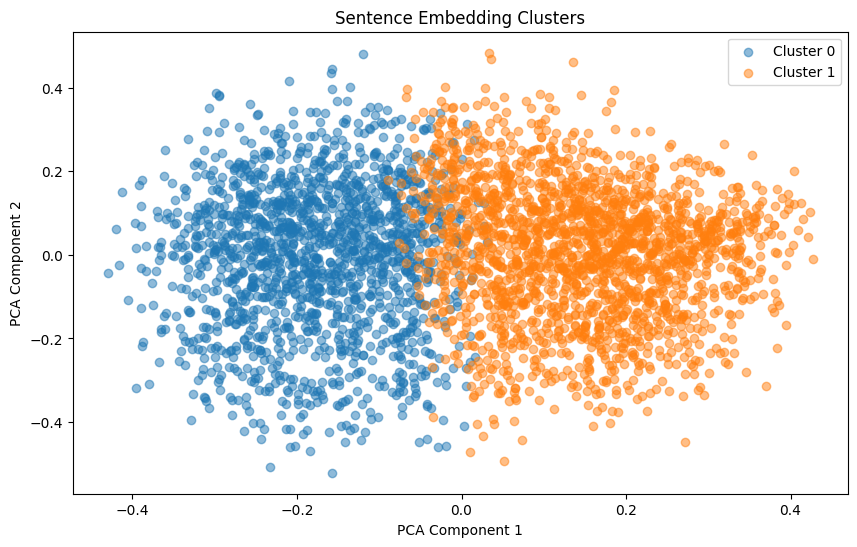

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    cluster_points = reduced_embeddings[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.5)
plt.legend()
plt.title("Sentence Embedding Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# Load sentence embeddings using Sentence-BERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = sbert_model.encode(eval_texts.tolist(), show_progress_bar=True)

# Apply K-Means clustering
num_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# Add cluster labels and true labels to a DataFrame
eval_texts_with_labels = pd.DataFrame({
    "text": eval_texts,
    "true_label": eval_labels,
    "cluster": cluster_labels
})




Batches: 100%|██████████| 111/111 [00:27<00:00,  4.02it/s]


In [ ]:
# Group by cluster and analyze label distribution
for cluster_id in range(num_clusters):
    cluster_data = eval_texts_with_labels[eval_texts_with_labels["cluster"] == cluster_id]
    label_counts = cluster_data["true_label"].value_counts()
    print(f"Cluster {cluster_id}:")
    print(label_counts)
    print("\n")


Cluster 0:
true_label
1    989
0    606
Name: count, dtype: int64


Cluster 1:
true_label
0    1180
1     766
Name: count, dtype: int64




In [ ]:
# Calculate purity
total_samples = len(eval_texts_with_labels)
purity = 0

for cluster_id in range(num_clusters):
    cluster_data = eval_texts_with_labels[eval_texts_with_labels["cluster"] == cluster_id]
    majority_label_count = cluster_data["true_label"].value_counts().max()
    purity += majority_label_count

purity /= total_samples
print(f"Cluster Purity: {purity:.4f}")


Cluster Purity: 0.6125


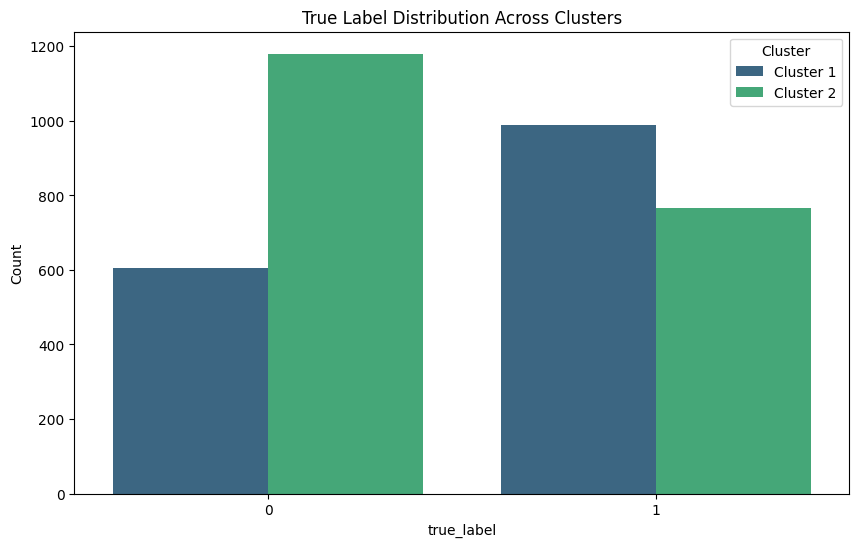

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot label distribution for each cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=eval_texts_with_labels, x="true_label", hue="cluster", palette="viridis")
plt.title("True Label Distribution Across Clusters")
plt.xlabel("true_label")
plt.ylabel("Count")
plt.legend(title="Cluster", labels=["Cluster 1", "Cluster 2"])
plt.show()


In [ ]:
# Group sentences by cluster
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id}:")
    cluster_sentences = eval_texts_with_labels[eval_texts_with_labels["cluster"] == cluster_id]["text"]
    print(cluster_sentences)  # Print first 5 sentences in this cluster
    print("\n")


Cluster 0:
15404     That somehow this bill is jeopardized by the ...
3752     While the president has complained that Comey ...
15942    She went on to say it was one thousand times w...
2051     The Republican nominee added that he also isn ...
4124      In connection with an unrelated case the FBI ...
                               ...                        
9669     In a Twitter thread the political aspirant voi...
2798     But it seems that Affleck won t actually be le...
11759    The firing of the director of strategic planni...
13528    It was the EU filled with an imperialist ambit...
13326     You cannot find a reasonable health care anal...
Name: text, Length: 1595, dtype: object


Cluster 1:
17699                            Jim Acosta August 22 2017
1527     More than 200 players either knelt or used oth...
9264     I am the daughter of an immigrant amp a daught...
11517    Key Fact In most states including North Caroli...
6201                         Matthew A Cherry June 

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(train_texts)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Analyze top features for biased and non-biased texts
biased_indices = np.where(train_labels == 1)[0]
non_biased_indices = np.where(train_labels == 0)[0]

biased_tfidf = tfidf_matrix[biased_indices].mean(axis=0).A1
non_biased_tfidf = tfidf_matrix[non_biased_indices].mean(axis=0).A1

# Top features
top_biased_indices = np.argsort(biased_tfidf)[::-1][:10]
top_non_biased_indices = np.argsort(non_biased_tfidf)[::-1][:10]

print("Top Biased Terms:")
for idx in top_biased_indices:
    print(f"{feature_names[idx]}: {biased_tfidf[idx]:.4f}")

print("\nTop Non-Biased Terms:")
for idx in top_non_biased_indices:
    print(f"{feature_names[idx]}: {non_biased_tfidf[idx]:.4f}")


Top Biased Terms:
trump: 0.0470
people: 0.0230
president: 0.0224
clinton: 0.0202
like: 0.0169
just: 0.0159
said: 0.0157
hillary: 0.0146
america: 0.0134
american: 0.0126

Top Non-Biased Terms:
said: 0.0332
trump: 0.0252
clinton: 0.0181
people: 0.0179
president: 0.0171
police: 0.0171
2017: 0.0149
news: 0.0121
just: 0.0114
time: 0.0109


In [ ]:
pip install textblob nltk vaderSentiment seaborn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from textblob import TextBlob
from nltk import pos_tag, word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def extract_features(text):
    # Ensure the text is valid
    if not isinstance(text, str) or not text.strip():
        return [0, 0, 0, 0]  # Default feature values for invalid text

    # Sentiment and polarity
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity  # Range [-1, 1]
    sentiment_subjectivity = blob.sentiment.subjectivity  # Range [0, 1]

    # VADER emotionality scores
    vader_scores = analyzer.polarity_scores(text)
    compound_sentiment = vader_scores["compound"]  # Overall sentiment score

    # Count adjectives
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    num_adjectives = sum(1 for word, tag in pos_tags if tag.startswith("JJ"))  # Adjectives

    # Feature vector
    return [
        sentiment_polarity,
        sentiment_subjectivity,
        compound_sentiment,
        num_adjectives
    ]

# Ensure no missing values in the dataset
df = eval_texts_with_labels.dropna(subset=["text", "true_label"])

# Apply feature extraction to the dataset
features = df["text"].apply(extract_features).tolist()

# Create the feature DataFrame and add true labels
feature_df = pd.DataFrame(features, columns=["Polarity", "Subjectivity", "Compound Sentiment", "Num Adjectives"])
feature_df["True Label"] = df["true_label"].values  # Add true labels


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
print(feature_df)

      Polarity  Subjectivity  Compound Sentiment  Num Adjectives  True Label
0     0.000000      0.000000              0.0000               0           1
1     0.093750      0.360417              0.1877               4           0
2     0.500000      0.500000              0.8126               3           1
3     0.000000      0.000000             -0.0258               0           1
4     0.004167      0.429167             -0.8885               6           0
...        ...           ...                 ...             ...         ...
3535 -0.031250      0.218750              0.0258               6           1
3536 -0.031994      0.320089             -0.8204               4           1
3537  0.300000      0.500000             -0.2732               4           1
3538  0.045000      0.305833             -0.5574               7           1
3539 -0.005000      0.475000              0.6808               4           1

[3540 rows x 5 columns]


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

# Apply K-Means clustering
num_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataset
feature_df["Cluster"] = cluster_labels
eval_texts_with_clusters = eval_texts.to_frame(name="text")
eval_texts_with_clusters["Cluster"] = cluster_labels


/tmp/ipykernel_1145/2913649031.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df, x="True Label", y=column, palette="viridis")
/tmp/ipykernel_1145/2913649031.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df, x="True Label", y=column, palette="viridis")
/tmp/ipykernel_1145/2913649031.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_df, x="True Label", y=column, palette="viridis")
/tmp/ipykernel_1145/2913649031.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecate

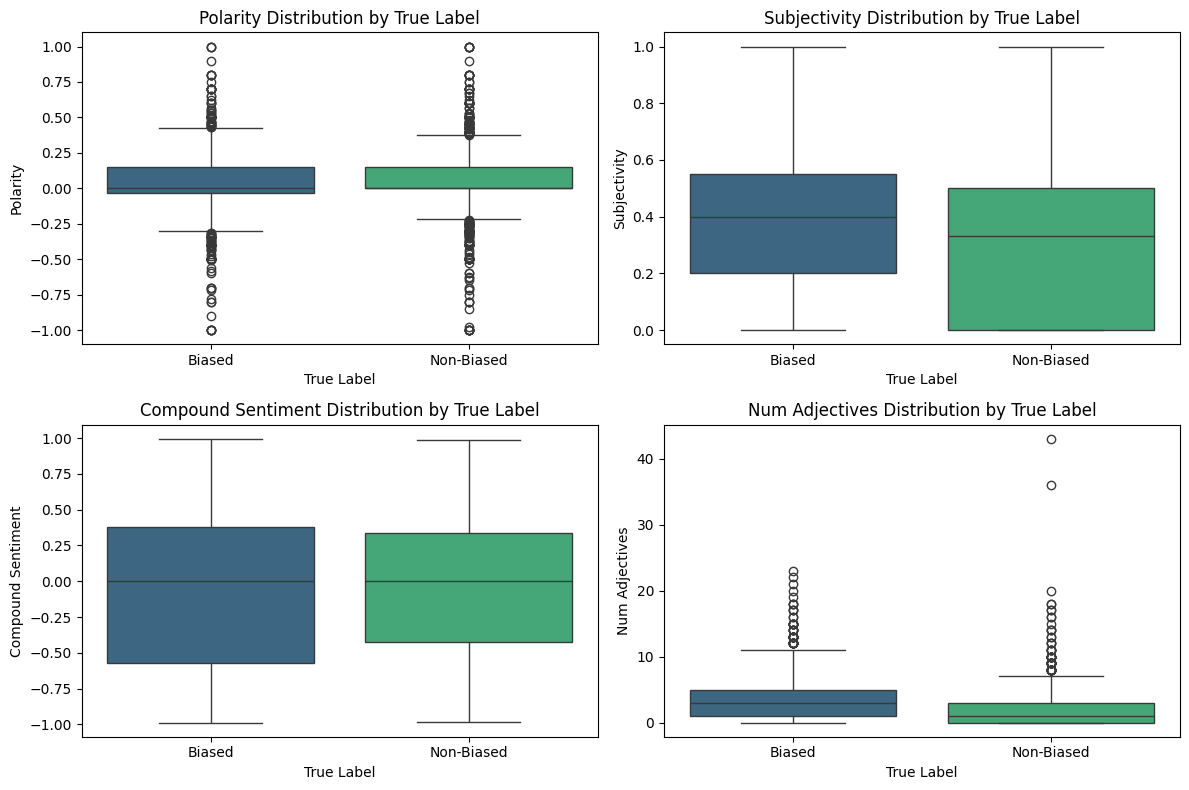

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map true labels to human-readable categories
feature_df["True Label"] = feature_df["True Label"].map({1: "Biased", 0: "Non-Biased"})

# Set up the plotting environment
plt.figure(figsize=(12, 8))

# Plot each feature
for i, column in enumerate(["Polarity", "Subjectivity", "Compound Sentiment", "Num Adjectives"], 1):
    plt.subplot(2, 2, i)  # Arrange subplots in a 2x2 grid
    sns.boxplot(data=feature_df, x="True Label", y=column, palette="viridis")
    plt.title(f"{column} Distribution by True Label")
    plt.xlabel("True Label")
    plt.ylabel(column)

plt.tight_layout()
plt.show()


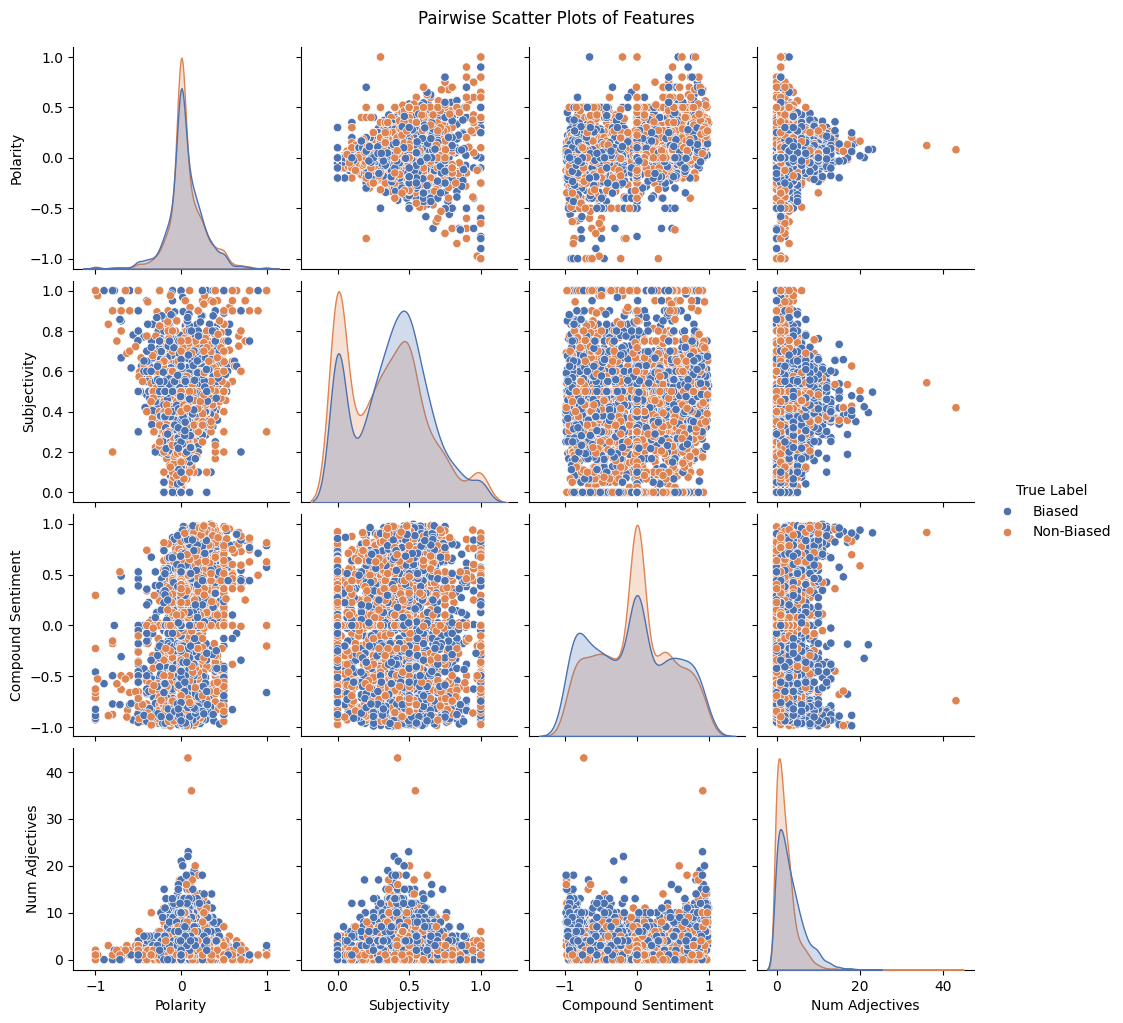

In [ ]:
sns.pairplot(
    feature_df,
    hue="True Label",
    vars=["Polarity", "Subjectivity", "Compound Sentiment", "Num Adjectives"],
    palette="deep",
    diag_kind="kde"
)
plt.suptitle("Pairwise Scatter Plots of Features", y=1.02)
plt.show()


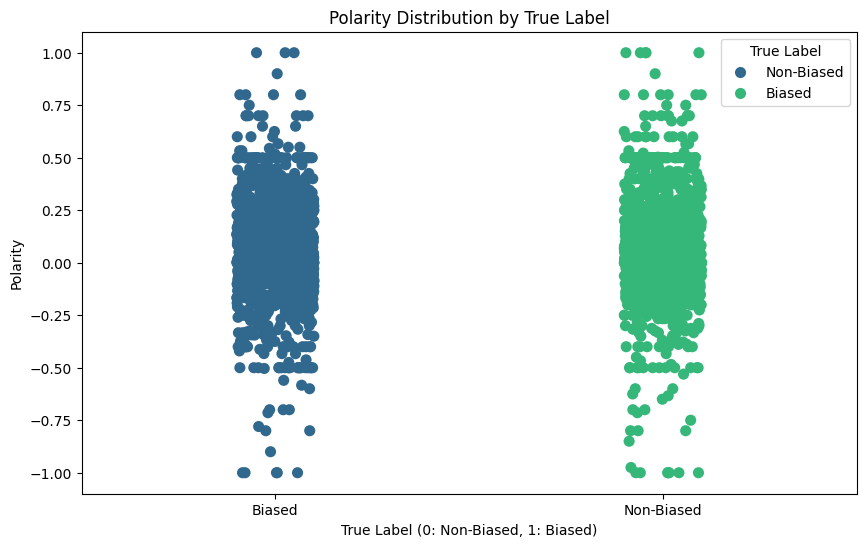

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot with True Label on the x-axis
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=feature_df,
    x="True Label",
    y="Polarity",
    hue="True Label",
    palette="viridis",
    jitter=True,  # Add jitter for better visualization
    size=8,  # Size of points
    dodge=False
)
plt.title("Polarity Distribution by True Label")
plt.xlabel("True Label (0: Non-Biased, 1: Biased)")
plt.ylabel("Polarity")
plt.legend(title="True Label", labels=["Non-Biased", "Biased"])
plt.show()


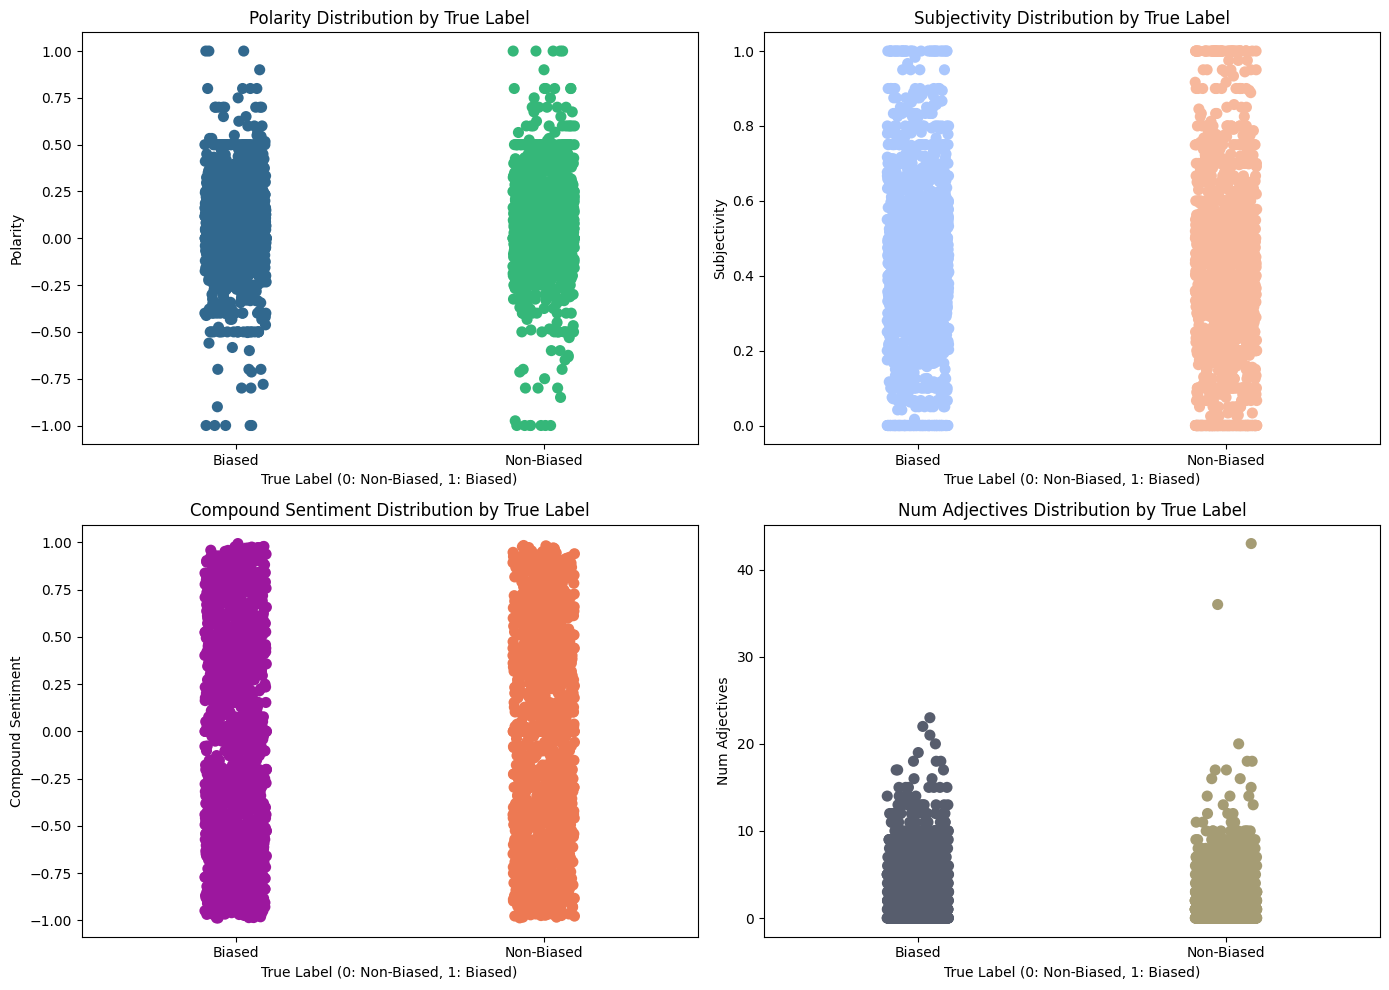

In [ ]:
# Set up a 2x2 grid for all features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features = ["Polarity", "Subjectivity", "Compound Sentiment", "Num Adjectives"]
palettes = ["viridis", "coolwarm", "plasma", "cividis"]

for ax, feature, palette in zip(axes.flatten(), features, palettes):
    sns.stripplot(
        data=feature_df,
        x="True Label",
        y=feature,
        hue="True Label",
        palette=palette,
        jitter=True,
        size=8,
        ax=ax
    )
    ax.set_title(f"{feature} Distribution by True Label")
    ax.set_xlabel("True Label (0: Non-Biased, 1: Biased)")
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()


In [ ]:
print(data['bias_rating'].value_counts())


bias_rating
left      10275
right      7226
center     4253
Name: count, dtype: int64


## Topic Modeling & Qualitative Comparison - classifiying topics